# Use tweets for evaluating the performances of an IR system

In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

In [2]:
import pymongo

## Create dataset and ground truth

In [3]:
db = pymongo.MongoClient()['twitter']['tweets']

In [4]:
tweets = list(db.find())

In [5]:
corpus = dict([(tweet['id'], tweet['text']) for tweet in tweets])

In [6]:
list(corpus.items())[:3]

[('1463847474049789952',
  'In case you missed it: Daily Covid-19 caseloads per 100,000 citizens in the UK now rank behind more than 10 European countries, including Belgium and Greece https://t.co/phSyAbo6Ux https://t.co/Swy51Zuf0B'),
 ('1463839920204787716',
  'English football is set for a radical makeover that would include powers to block change of ownership of clubs, a veto for supporters over key decisions and a redistributive levy on Premier League player transfers, under proposals by a review of the sport https://t.co/f2Xr75Jdhq'),
 ('1463836848917204998',
  'Good Morning New York. Here are the Top Stories Today.\nhttps://t.co/zHRPaGT1ib https://t.co/qvKD7BflG7')]

In [7]:
entities, domains = {}, {}
metadata = []
for i, tweet in enumerate(tweets):
    if 'context_annotations' in tweet.keys():
        for annotation in tweet['context_annotations']:
            domain, entity = annotation['domain'], annotation['entity']
            if domain['id'] not in domains:
                domains[domain['id']] = domain
            if entity['id'] not in entities:
                entities[entity['id']] = entity
            metadata.append({
                'entity': entity['id'], 'domain': domain['id'], 'tweet': tweet['id']
            })
M = pd.DataFrame(metadata)

In [8]:
E = pd.DataFrame(entities).T
D = pd.DataFrame(domains).T

In [9]:
E.head(2)

,id,name,description
1220701888179359745,1220701888179359745,COVID-19,NaN
10000277815,10000277815,English Premier League Soccer,Action from English Premier League Soccer matc...


In [10]:
D.head(2)

,id,name,description
123,123,Ongoing News Story,Ongoing News Stories like 'Brexit'
3,3,TV Shows,Television shows from around the world


In [11]:
M.head(2)

,entity,domain,tweet
0,1220701888179359745,123,1463847474049789952
1,10000277815,3,1463839920204787716


## Expected results

In [12]:
entity_queries = list(set(E['name'].values))
domain_queries = list(set(D['name'].values))
indexed_tweets = set([int(x) for x in list(E.id.values) + list(D.id.values)])

In [13]:
def get_entity_results(query):
    etweets = set()
    entity_ids = E[E['name']==query].id.values
    for eid in entity_ids:
        etweets = etweets.union(set(M[M.entity==eid].tweet.values))
    return etweets

def get_domain_results(query):
    etweets = set()
    domain_ids = D[D['name']==query].id.values
    for eid in domain_ids:
        etweets = etweets.union(set(M[M.domain==eid].tweet.values))
    return etweets

In [14]:
len(get_domain_results('TV Shows'))

2042

In [15]:
list(get_domain_results('TV Shows'))[:3]

['1470731673864183816', '1475082387096838148', '1491336099213553666']

In [16]:
search_base = [(x, corpus[x]) for x in set(M.tweet.values)]

In [17]:
len(search_base)

22350

In [18]:
esize = M.groupby('entity').count()
esize['query'] = [E.loc[x]['name'] for x in esize.index.values]
dsize = pd.DataFrame(M.groupby('domain').tweet.nunique(), columns=['tweet'])
dsize['query'] = [D.loc[x]['name'] for x in dsize.index.values]

In [19]:
esize.sort_values('tweet', ascending=False).head(20)

,domain,tweet,query
entity,,,
781974596148793345,4427,4427,Business & finance
1220701888179359745,3985,3985,COVID-19
1066114840832356353,3074,3074,The Telegraph
1113138554496942080,3071,3071,The Daily Telegraph
1113097508572426242,2983,2983,Daily Mirror
1066122339568386048,2819,2819,The Guardian
857212166100754432,1964,1964,Boris Johnson
825047692124442624,1661,1661,Food
864931126132985856,1198,1198,Vladimir Putin


In [20]:
dsize.sort_values('tweet', ascending=False).head(20)

,tweet,query
domain,,
47,10721,Brand
10,6368,Person
65,5525,Interests and Hobbies Vertical
123,3980,Ongoing News Story
45,3331,Brand Vertical
35,2961,Politician
66,2681,Interests and Hobbies Category
67,2573,Interests and Hobbies
3,2042,TV Shows


### Example

In [21]:
query_answers = get_entity_results('COVID-19')
y_true = [1 if x in query_answers else 0 for x, _ in search_base]

In [22]:
index_true = [i for i, x in enumerate(y_true) if x == 1]
for i in index_true[:5]:
    print(search_base[i])

('1472691996284313612', 'SAGE calls for closure of non-essential shops in bid to prevent 6,000 daily Omicron deaths https://t.co/6je9DpEc2b')
('1468535870995243008', 'FT Exclusive: The UK government is set to implement the so-called Plan B of further restrictions, including requiring vaccine passports for large venues and an order to work from home https://t.co/UjUYAQljmk https://t.co/QnRfvQlWjh')
('1481903933043970048', "RICHARD LITTLEJOHN: Boris's booze-up proves that he knew lockdown was bonkers https://t.co/ur5jMVbY2U")
('1471805733138280460', 'RT @TelGlobalHealth: 💉 Pharmaceutical leaders admit "we dismally failed" at global Covid #vaccine rollout.\n\n🌍 Thomas Cueni, head of a major…')
('1470951747405455362', 'Long lines continue at UK vaccination centres as people rush for their booster jab https://t.co/THAI9oSirG')


In [23]:
len(index_true)

3980

## The naive information system
- Create the index as BOW and Inverted index
- Compute pseudo cosine similarity
- Transform the query
- Perform evaluation

In [24]:
from nltk.tokenize import TweetTokenizer
from collections import defaultdict, Counter

In [25]:
from nltk.corpus import stopwords
from string import punctuation

In [26]:
stopw = set(stopwords.words('english'))
tokenizer = TweetTokenizer()
tokenize = lambda text: [word for word in tokenizer.tokenize(text.lower()) 
                         if word not in punctuation and word not in stopw and not word.startswith('http')] 

In [27]:
BOW = defaultdict(lambda: defaultdict(lambda: 0))
I = defaultdict(set)

In [28]:
for i, text in search_base:
    for token in tokenize(text):
        BOW[i][token] += 1
        I[token].add(i)

### TFIDF from scratch

In [29]:
N = len(search_base)
IDF = dict([(word, np.log(N / len(posting))) for word, posting in I.items()])
TFIDF = {}
for document, bow in BOW.items():
    size = sum(bow.values())
    tfidf_bow = dict([(word, (tf / size) * IDF[word]) for word, tf in bow.items()])
    TFIDF[document] = tfidf_bow

In [30]:
list(TFIDF.items())[0]

('1475082387096838148',
 {'rt': 0.12096202398349429,
  '@mirrorsport': 0.3834161199161903,
  'lewis': 0.3115342781615659,
  'hamilton': 0.32845675301167065,
  'vs': 0.4100034801363701,
  'max': 0.3502434464408997,
  'verstappen': 0.37358940905365107,
  'toto': 0.4598445307473821,
  'wolff': 0.46677294460952223,
  'christian': 0.38166006326032664,
  'horner': 0.46677294460952223,
  'war': 0.26176830545406005,
  'f1': 0.3664936450660855,
  'greatest': 0.40726700862843523,
  'season': 0.32572028150373583,
  'ht': 0.3834161199161903,
  '…': 0.17086483158643787})

### Search

In [31]:
def query(query_text):
    counts = Counter(tokenize(query_text)).most_common()
    qtfidf = [(w, tf * IDF[w]) for w, tf in counts if w in IDF.keys()]
    return qtfidf

In [32]:
query('COVID-19')

[('covid', 2.4186916823231766), ('19', 4.65328943433229)]

### Pseudo cosine similarity
$$
\cos(\theta) = \frac{{\textbf x} \cdot {\textbf y}}{{\mid\mid {\textbf x} \mid\mid \mid\mid {\textbf y} \mid\mid}} = 
\frac{\sum\limits_{i=1}^{N} a_i b_i}{\sqrt{\sum\limits_{i=1}^{N} a_{i}^{2}} \sqrt{\sum\limits_{i=1}^{N} b_{i}^{2}}}
$$

In [33]:
def cos(bow1, bow2):
    sq1 = np.sqrt(sum([np.power(x, 2) for x in bow1.values()]))
    sq2 = np.sqrt(sum([np.power(x, 2) for x in bow2.values()]))
    k = 0
    for word, score in bow1.items():
        try:
            k += score * bow2[word]
        except KeyError:
            pass
    score = k / (sq1 * sq2)
    if pd.isna(score):
        score = 0
    return score

In [34]:
list(TFIDF.keys())[:4]

['1475082387096838148',
 '1472691996284313612',
 '1470376087989460998',
 '1471052743313870858']

In [35]:
print(TFIDF['1466323790753845253'])
print(TFIDF['1474394435656065042'])

{'prime': 0.481057491296492, 'minister': 0.4348154911929283, 'criticises': 0.8068671450986402, 'facebook': 0.5632554965367834, 'social': 0.5235458106930185, 'media': 0.548198210688846, 'companies': 0.5429614121371144, 'migrant': 0.637699544031533, 'trafficking': 0.6718744734037386, 'adverts': 0.8915969311373605}
{'🥂': 0.2711336673421811, 'winston': 0.28761191327011626, 'churchill': 0.26525232680044064, 'hailed': 0.22641449440282982, 'pint': 0.24877408087250544, 'bottle': 0.2280691168024282, 'champagne': 0.21921631532817787, '“': 0.22012862631305666, 'ideal': 0.26525232680044064, 'size': 0.23792013775569212, '”': 0.2240070735183813, 'declaring': 0.27833184641683306, 'enough': 0.1751488426248756, 'two': 0.13143259184907366, 'lunch': 0.1962179344295932, 'one': 0.11762562624810395, 'dinner': 0.17231460534128415, 'sale': 0.1855452168709806, 'wartime': 0.32305101935618435, 'prime': 0.15517983590209417, 'minister': 0.14026306167513813, '’': 0.05764319006894471, 'favoured': 0.28761191327011626

In [36]:
cos(TFIDF['1466323790753845253'], TFIDF['1474394435656065042'])

0.057594817449885274

### Search

In [37]:
def search(query_text):
    q = dict(query(query_text))
    outcomes = []
    for doc_id, text in search_base:
        outcomes.append((doc_id, cos(q, BOW[doc_id])))
    return outcomes

In [38]:
out = search('COVID-19')

/var/folders/cn/1cnswmps6xsbv3x70vr8z3v80000gn/T/ipykernel_3143/67236475.py:10: RuntimeWarning: invalid value encountered in double_scalars
  score = k / (sq1 * sq2)


In [39]:
out[:4]

[('1475082387096838148', 0.0),
 ('1472691996284313612', 0.0),
 ('1470376087989460998', 0.0),
 ('1471052743313870858', 0.0)]

### Output selection or ranking?

In [95]:
ground_truth = get_entity_results('COVID-19')

In [142]:
TP, FP, FN, TN, answers = 0, 0, 0, 0, []
threshold = np.percentile(np.array([y for x, y in out]), 97)
for doc_id, score in out:
    if score >= threshold:
        answers.append((doc_id, score))
        if doc_id in ground_truth:
            TP += 1
        else:
            FP += 1
    else:
        if doc_id in ground_truth:
            FN += 1
        else:
            TN += 1

In [97]:
print('precision', TP / (TP + FP))
print('recall', TP / (TP + FN))

precision 1.0
recall 0.0017587939698492463


In [98]:
print(TP, FP, FN, TN)

7 0 3973 18370


In [44]:
print((TP + TN) / (TP + TN + FP + FN))

0.8578076062639821


In [47]:
for i, (doc_id, score) in enumerate(answers):
    if not doc_id in ground_truth:
        print(doc_id, score)
        print(corpus[doc_id])
        break

1484131341226500099 0.29576543565613694
#homesunderthehammer Martin Roberts breaks silence on future on show after 19 years
https://t.co/m9EE8BYkTo


In [48]:
A = set([x for x, y in answers])
c = 0
for doc_id in ground_truth:
    if not doc_id in A:
        print(corpus[doc_id])
        c += 1
    if c > 4:
        break

New place named UK's Covid capital as 170 areas see a rise - view the list
https://t.co/6fFG0gETLH https://t.co/ID9UBT58bp
Interview: Former Tory minister Lord Agnew tells @aliceTTimes why he resigned over the government’s failure to tackle Covid fraud https://t.co/R92z0OWG1k
Brian May: Queen legend 'haunted and sickened' by sad video as he recovers from Covid https://t.co/PeyiNw7YlL
SAGE calls for closure of non-essential shops in bid to prevent 6,000 daily Omicron deaths https://t.co/6je9DpEc2b
Masks 'to stay until New Year' amid Omicron crisis as PM fights to 'save Xmas' https://t.co/CVdHn4UY6E


### Sklearn metrics

In [59]:
import matplotlib.pyplot as plt

In [49]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [92]:
y_true[:5]

[0, 1, 0, 0, 0]

In [57]:
A = set([x for x, y in answers])
y_pred = [1 if x in A else 0 for x, y in search_base]

In [93]:
y_pred[:5]

[0, 0, 0, 0, 0]

In [58]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92     18370
           1       0.96      0.21      0.34      3980

    accuracy                           0.86     22350
   macro avg       0.91      0.60      0.63     22350
weighted avg       0.87      0.86      0.82     22350



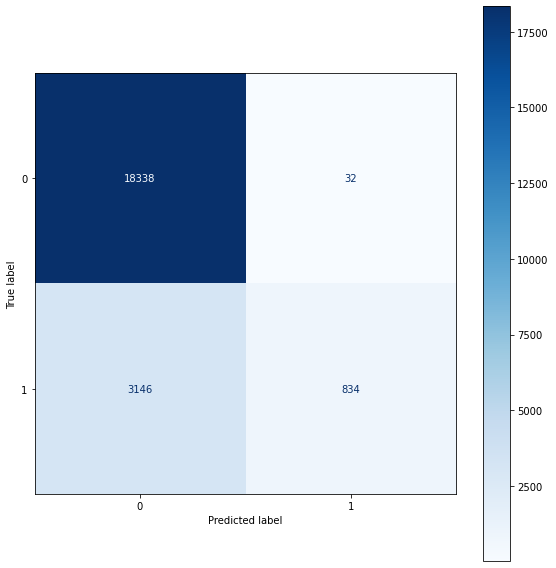

In [94]:
fig, ax = plt.subplots(figsize=(8, 8))
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(ax=ax, cmap='Blues')
plt.tight_layout()
plt.show()

### Ranking scores

In [77]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

In [100]:
ranking = sorted(out, key=lambda x: -x[1])

In [109]:
rank_score = 0
for i, (doc, score) in enumerate(ranking):
    if doc in ground_truth:
        rank_score += 1 / np.log(i + 2)

In [110]:
rank_score

527.5194222330949

### Ranking evaluation

In [113]:
TP, FP, FN, TN = 0, 0, len(ground_truth), len(ranking) - len(ground_truth)
precision, recall = [], []
for i, (doc, score) in enumerate(ranking):
    if doc in ground_truth:
        TP += 1
        FN -= 1
    else:
        FP += 1
        TN -= 1
    precision.append(TP / (TP + FP))
    recall.append(TP / (TP + FN))

In [115]:
i_precision = [max(precision[i:]) for i in range(len(precision))]

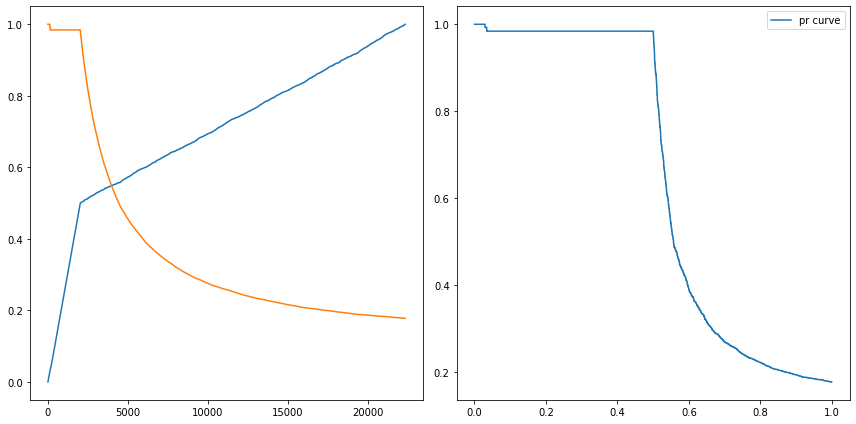

In [120]:
fig, ax = plt.subplots(figsize=(12, 6), ncols=2)
ax[0].plot(recall, label='recall')
ax[0].plot(i_precision, label='precision')
ax[1].plot(recall, i_precision, label='pr curve')
plt.legend()
plt.tight_layout()
plt.show()

In [121]:
O = dict(out)
y_scores = [O[x] for x, y in search_base]

In [122]:
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)

In [123]:
precision[:3], recall[:3], thresholds[:3]

(array([0.17807606, 0.98417409, 0.98416625]),
 array([1.        , 0.5       , 0.49974874]),
 array([0.        , 0.04916406, 0.07202731]))

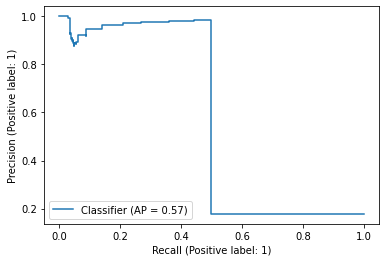

In [79]:
display = PrecisionRecallDisplay.from_predictions(y_true, y_scores)
plt.show()

In [124]:
rec = list(sorted(recall, key=lambda x: x))
prec = list(sorted(precision, key=lambda x: -x))
iprec = [max(prec[i:]) for i in range(len(prec))]

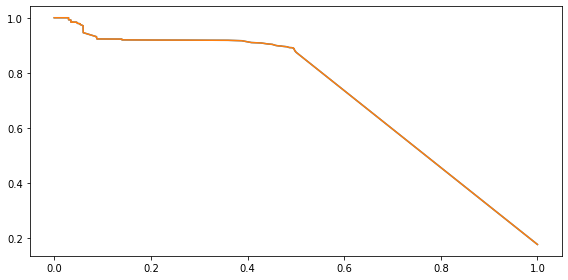

In [125]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(rec, prec)
ax.plot(rec, iprec)
plt.tight_layout()
plt.show()

## Query expansion

In [154]:
def avg(bag_of_words):
    vocabulary = set()
    for bow in bag_of_words:
        for word in bow.keys():
            vocabulary.add(word)
    new_bow = {}
    for key in vocabulary:
        values = [b[key] if key in b.keys() else 0 for b in bag_of_words]
        new_bow[key] = np.array(values).mean()
    return new_bow

def rocchio(original_q, positive_f, negative_f, alpha=0.75, beta=0.20, gamma=0.05):
    vocabulary = set()
    for bow in [original_q, positive_f, negative_f]:
        for word in bow.keys():
            vocabulary.add(word)
    new_bow = {}
    for key in vocabulary:
        try:
            oq = original_q[key]
        except KeyError:
            oq = 0
        try:
            pq = positive_f[key]
        except KeyError:
            pq = 0
        try:
            nq = negative_f[key]
        except KeyError:
            nq = 0
        new_bow[key] = alpha*oq + beta*pq - gamma*nq
    return new_bow

In [155]:
positive_feedback = [BOW[x] for x in list(ground_truth)[:20]]

In [156]:
negative_feedback = []
for doc, score in answers:
    if doc not in ground_truth:
        negative_feedback.append(BOW[doc])

In [157]:
pfbow = avg(positive_feedback)
nfbow = avg(negative_feedback)

In [158]:
query('COVID-19')

[('covid', 2.4186916823231766), ('19', 4.65328943433229)]

In [160]:
nquery = rocchio(dict(query('COVID-19')), pfbow, nfbow)

In [161]:
def rocchio_search(q):
    outcomes = []
    for doc_id, text in search_base:
        outcomes.append((doc_id, cos(q, BOW[doc_id])))
    return outcomes

In [162]:
rout = rocchio_search(nquery)

/var/folders/cn/1cnswmps6xsbv3x70vr8z3v80000gn/T/ipykernel_3143/67236475.py:10: RuntimeWarning: invalid value encountered in double_scalars
  score = k / (sq1 * sq2)


In [163]:
rout[:3]

[('1475082387096838148', 0.0007500226945008818),
 ('1472691996284313612', 0.013770838947376806),
 ('1470376087989460998', 0.00975734397592184)]

In [167]:
TP, FP, FN, TN, answers = 0, 0, 0, 0, []
threshold = np.percentile(np.array([y for x, y in rout]), 95)
for doc_id, score in rout:
    if score >= threshold:
        answers.append((doc_id, score))
        if doc_id in ground_truth:
            TP += 1
        else:
            FP += 1
    else:
        if doc_id in ground_truth:
            FN += 1
        else:
            TN += 1

In [168]:
print('precision', TP / (TP + FP))
print('recall', TP / (TP + FN))

precision 0.9714795008912656
recall 0.27386934673366836


In [166]:
rranking = sorted(rout, key=lambda x: -x[1])

In [169]:
rO = dict(rout)
y_rscores = [rO[x] for x, y in search_base]

In [170]:
precision, recall, thresholds = precision_recall_curve(y_true, y_rscores)

In [171]:
rec = list(sorted(recall, key=lambda x: x))
prec = list(sorted(precision, key=lambda x: -x))
iprec = [max(prec[i:]) for i in range(len(prec))]

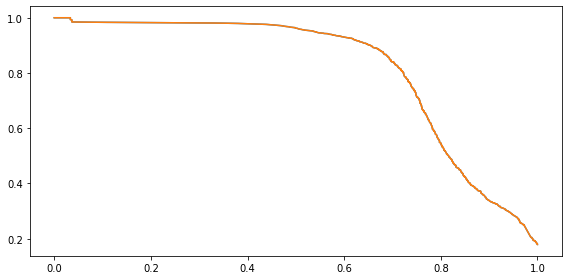

In [172]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(rec, prec)
ax.plot(rec, iprec)
plt.tight_layout()
plt.show()

In [173]:
A = set([x for x, y in answers])
y_pred = [1 if x in A else 0 for x, y in search_base]

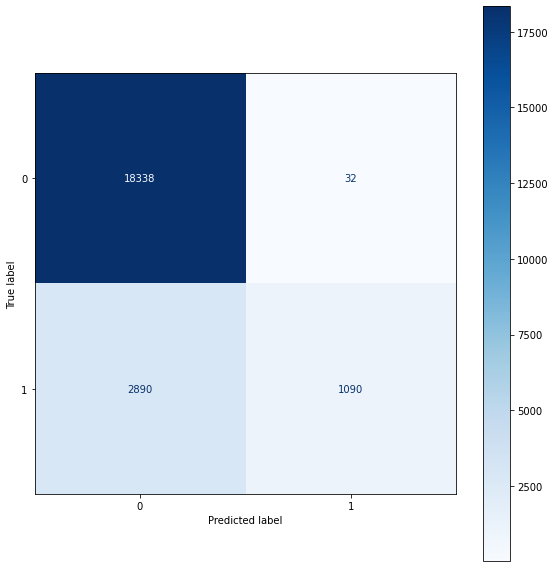

In [174]:
fig, ax = plt.subplots(figsize=(8, 8))
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(ax=ax, cmap='Blues')
plt.tight_layout()
plt.show()